In [ ]:
!pip install keras==2.15.0
!pip install tensorflow==2.15.0
# !pip install tensorflow_model_optimization==0.8.0

In [ ]:
!pip install scikit-image==0.22.0
!pip install matplotlib==3.7.5
!pip install numpy==1.26.4
!pip install pandas==2.2.2
!pip install scikit-learn==1.2.2
!pip install beautifulsoup4==4.12.2

In [1]:
import os
import random
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import skimage
from skimage import io
import bs4
from bs4 import BeautifulSoup

# Print versions
versions = {
    'numpy': np.__version__,
    'tensorflow': tf.__version__,
    'matplotlib': matplotlib.__version__,
    'pandas': pd.__version__,
    'sklearn': sklearn.__version__,
    'skimage': skimage.__version__,
    'beautifulsoup4': bs4.__version__
}
for lib, version in versions.items():
    print(f'{lib}: {version}')

# Determinism
tf.config.experimental.enable_op_determinism
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



numpy: 1.26.4
tensorflow: 2.15.0
matplotlib: 3.7.5
pandas: 2.2.2
sklearn: 1.2.2
skimage: 0.22.0
beautifulsoup4: 4.12.2


In [2]:
def load_xml_annotations(directory, fn_parse_annotation):
    annotations = []
    for filename in os.listdir(directory):
        if filename.endswith('.xml'):
            file_path = os.path.join(directory, filename)
            tree = ET.parse(file_path)
            annotation_item = fn_parse_annotation(tree.getroot())
            annotations.append(annotation_item)
    return annotations

def display_images(df_original, num_elements):
    if num_elements == 1:
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        ax[0].set_title('Input'); ax[1].set_title('Expected result')
    else:
        fig, ax = plt.subplots(num_elements, 2, figsize=(10, 4 * num_elements))
        ax[0, 0].set_title('Input'); ax[0, 1].set_title('Expected result')

    for i in range(num_elements):
        display_data = df_original.iloc[i]
        image = io.imread(display_data["filename"])
        if num_elements == 1:
            ax[0].imshow(image); ax[1].imshow(image)
            w = display_data['xmax'] - display_data['xmin']
            h = display_data['ymax'] - display_data['ymin']
            ax[1].add_patch(patches.Rectangle((display_data['xmin'], display_data['ymin']),
                                              w, h, fill=False, color='lime', linewidth=2))
            for a in ax: a.set_xticks([]); a.set_yticks([])
        else:
            ax[i, 0].imshow(image); ax[i, 1].imshow(image)
            w = display_data['xmax'] - display_data['xmin']
            h = display_data['ymax'] - display_data['ymin']
            ax[i, 1].add_patch(patches.Rectangle((display_data['xmin'], display_data['ymin']),
                                                 w, h, fill=False, color='lime', linewidth=2))
            for a in (ax[i,0], ax[i,1]): a.set_xticks([]); a.set_yticks([])
    plt.tight_layout(); plt.show()

def plot_history(history, model_evaluation_info=""):
    epochs_range = range(1, len(history.history['loss'])+1)
    plt.figure(num='Training Result', figsize=(12, 6))
    if model_evaluation_info:
        plt.suptitle(model_evaluation_info, fontsize=13)



    # Loss (total)
    plt.subplot(1, 2, 2)
    plt.title('Total Loss')
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(loc='upper right')

    plt.tight_layout(); plt.subplots_adjust(wspace=0.2); plt.show()

def load_normalize_image(image_path, img_size, channels=1):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=channels)
    image = tf.image.resize(image, size=img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def create_dataset_from_dataframe(dataframe, use_norm_cols=True):
    image_paths = tf.cast(dataframe['filename'].values, tf.string)

    if use_norm_cols:
        cols = ['xmin_n', 'ymin_n', 'xmax_n', 'ymax_n']
    else:
        cols = ['xmin', 'ymin', 'xmax', 'ymax']

    image_coordinates = tf.cast(dataframe[cols].values, tf.float32)
    class_ids = tf.cast(dataframe['class_id'].values, tf.int32)
    # Output structure must match model outputs order: ('bbox', 'class')
    ds = tf.data.Dataset.from_tensor_slices((image_paths, (image_coordinates, class_ids)))
    return ds

def plot_predictions(pred_bboxes, pred_classes, dataframe_original, box_color='lime', class_names=None):
    num_predictions = len(pred_bboxes)
    fig, ax = plt.subplots(num_predictions, 2, figsize=(12, num_predictions * 4))
    if num_predictions == 1:
        ax = np.array([[ax[0], ax[1]]])  # normalize shape

    for i in range(num_predictions):
        expected = dataframe_original.iloc[i]
        image = io.imread(expected['filename'])
        h, w = image.shape[:2]   # actual dims

        # Scale predicted normalized bbox back to original image size
        pb = pred_bboxes[i] * np.array([w, h, w, h])  
        pw, ph = pb[2] - pb[0], pb[3] - pb[1]

        # Scale expected normalized bbox back to original image size
        eb = np.array([
            expected['xmin_n'] * w,
            expected['ymin_n'] * h,
            expected['xmax_n'] * w,
            expected['ymax_n'] * h
        ])
        ew, eh = eb[2] - eb[0], eb[3] - eb[1]

        # Left: prediction
        ax[i, 0].imshow(image)
        ax[i, 0].add_patch(patches.Rectangle((pb[0], pb[1]), pw, ph, fill=False, color=box_color, linewidth=2))
        pred_label = int(pred_classes[i])
        pred_text = class_names[pred_label] if class_names else str(pred_label)
        ax[i, 0].text(pb[0], max(pb[1]-5, 0), pred_text, fontsize=10,
                      bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        # Right: ground truth
        ax[i, 1].imshow(image)
        ax[i, 1].add_patch(patches.Rectangle((eb[0], eb[1]), ew, eh, fill=False, color=box_color, linewidth=2))
        true_text = class_names[expected['class_id']] if class_names else str(expected['class_id'])
        ax[i, 1].text(eb[0], max(eb[1]-5, 0), true_text, fontsize=10,
                      bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        for a in (ax[i,0], ax[i,1]):
            a.set_xticks([]); a.set_yticks([])

    plt.tight_layout(); plt.show()

In [3]:
# Directories
DIR_ROOT = '/obj_detect_file/simple_obj_detect'
DIR_IMAGES = f'{DIR_ROOT}/datasets/watergun'
DIR_ANNOTATIONS = f'{DIR_ROOT}/datasets/watergun annotations'

In [4]:
CLASSES = ["Water Gun"]  

def parse_annotation(root):
    annotation = {}
    annotation['filename'] = f'{DIR_IMAGES}/{root.find("filename").text}'
    annotation['width'] = int(root.find('size/width').text)
    annotation['height'] = int(root.find('size/height').text)

    # single object per image assumption
    obj = root.find('object')
    class_name = obj.find('name').text.strip()
    if class_name not in CLASSES:
        raise ValueError(f"Class '{class_name}' not in CLASSES {CLASSES}. Fix your list or labels.")

    annotation['class_id'] = CLASSES.index(class_name)

    bb = obj.find('bndbox')
    annotation['xmin'] = int(bb.find('xmin').text)
    annotation['ymin'] = int(bb.find('ymin').text)
    annotation['xmax'] = int(bb.find('xmax').text)
    annotation['ymax'] = int(bb.find('ymax').text)
    return annotation

# Load & build dataframe
annotations = load_xml_annotations(DIR_ANNOTATIONS, parse_annotation)
dataframe_original = pd.DataFrame(annotations)

# Normalize bbox to [0,1] using original image dimensions (robust to any size)
df = dataframe_original.copy()
df['xmin_n'] = df['xmin'] / df['width']
df['ymin_n'] = df['ymin'] / df['height']
df['xmax_n'] = df['xmax'] / df['width']
df['ymax_n'] = df['ymax'] / df['height']

# sanity clip
for c in ['xmin_n','ymin_n','xmax_n','ymax_n']:
    df[c] = df[c].clip(0.0, 1.0)

df.head()


,filename,width,height,class_id,xmin,ymin,xmax,ymax,xmin_n,ymin_n,xmax_n,ymax_n
0,/obj_detect_file/simple_obj_detect/datasets/wa...,3000,4000,0,214,1503,2548,2974,0.071333,0.37575,0.849333,0.74350
1,/obj_detect_file/simple_obj_detect/datasets/wa...,1800,4000,0,614,1446,1431,2539,0.341111,0.36150,0.795000,0.63475
2,/obj_detect_file/simple_obj_detect/datasets/wa...,1800,4000,0,590,1516,1653,2365,0.327778,0.37900,0.918333,0.59125
3,/obj_detect_file/simple_obj_detect/datasets/wa...,1800,4000,0,664,1414,1766,2187,0.368889,0.35350,0.981111,0.54675
4,/obj_detect_file/simple_obj_detect/datasets/wa...,1800,4000,0,115,1685,1735,2709,0.063889,0.42125,0.963889,0.67725


TOTAL IMAGES: 121
SAMPLE IMAGE SHAPE: (4000, 3000, 3)


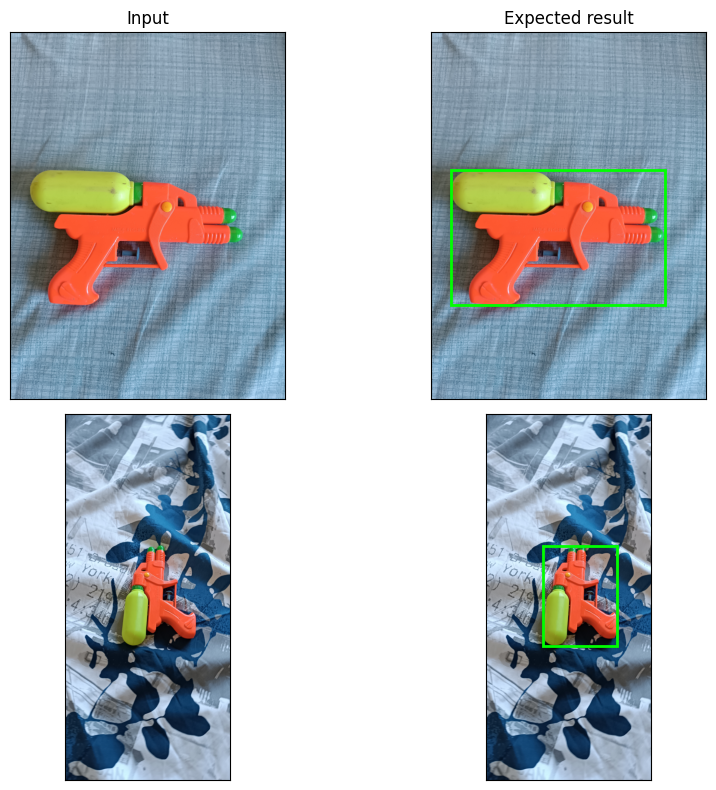

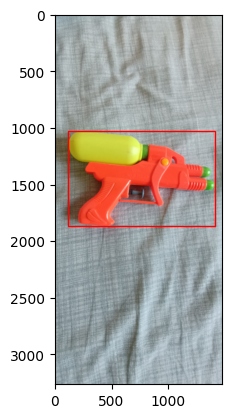

In [5]:
print("TOTAL IMAGES:", len(df))
sample_shape = io.imread(df.iloc[0]['filename']).shape
print('SAMPLE IMAGE SHAPE:', sample_shape)
display_images(dataframe_original, min(2, len(df)))

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io

row = df.sample(1).iloc[0]
image = io.imread(row['filename'])
h, w = image.shape[:2]
x1, y1, x2, y2 = row['xmin_n']*w, row['ymin_n']*h, row['xmax_n']*w, row['ymax_n']*h

fig, ax = plt.subplots(1)
ax.imshow(image)
ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, color='red'))
plt.show()

In [6]:
# Parameters
BUFFER_SIZE = 200
BATCH_SIZE = 10
SIZE = 340  # final resize target (square)

# Train/Val split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True, stratify=df['class_id'])

# Train Dataset
train_ds = create_dataset_from_dataframe(train_df, use_norm_cols=True)
map_func = lambda path, labels: (load_normalize_image(path, [SIZE, SIZE], channels=1), labels)
train_ds = (train_ds
            .map(map_func=map_func, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(BUFFER_SIZE)
            .cache()
            .repeat()
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=tf.data.AUTOTUNE))
train_steps = max(1, len(train_df) // BATCH_SIZE)

# Val Dataset
val_ds = create_dataset_from_dataframe(val_df, use_norm_cols=True)
val_ds = (val_ds
          .map(map_func=map_func, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .repeat()
          .batch(BATCH_SIZE)
          .prefetch(buffer_size=tf.data.AUTOTUNE))
val_steps = max(1, len(val_df) // BATCH_SIZE)

print("Elements in train:", len(train_df), "| steps:", train_steps)
print("Elements in val  :", len(val_df),   "| steps:", val_steps)
train_df.head()


Elements in train: 96 | steps: 9
Elements in val  : 25 | steps: 2


,filename,width,height,class_id,xmin,ymin,xmax,ymax,xmin_n,ymin_n,xmax_n,ymax_n
96,/obj_detect_file/simple_obj_detect/datasets/wa...,4000,1800,0,1296,279,2084,1515,0.324000,0.155000,0.521000,0.841667
118,/obj_detect_file/simple_obj_detect/datasets/wa...,4000,1800,0,1629,356,2384,1463,0.407250,0.197778,0.596000,0.812778
48,/obj_detect_file/simple_obj_detect/datasets/wa...,4000,1800,0,1390,69,2769,1207,0.347500,0.038333,0.692250,0.670556
0,/obj_detect_file/simple_obj_detect/datasets/wa...,3000,4000,0,214,1503,2548,2974,0.071333,0.375750,0.849333,0.743500
95,/obj_detect_file/simple_obj_detect/datasets/wa...,4000,1800,0,1645,542,2309,1393,0.411250,0.301111,0.577250,0.773889


In [7]:
# Model params
INPUT_SHAPE = (SIZE, SIZE, 1)
FIT_EPOCHS = 20

# Callbacks
FIT_CALLBACKS = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, min_delta=1e-3,
                                     restore_best_weights=True, verbose=1)
]

# Backbone
inputs = tf.keras.Input(shape=INPUT_SHAPE, name='input_layer')
x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', name='conv1')(inputs)
x = tf.keras.layers.MaxPool2D(name='pool1')(x)
x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', name='conv2')(x)
x = tf.keras.layers.MaxPool2D(name='pool2')(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', name='conv3')(x)
x = tf.keras.layers.MaxPool2D(name='pool3')(x)
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.Dense(512, activation='relu', name='dense1')(x)
x = tf.keras.layers.Dense(128, activation='relu', name='dense2')(x)

# Heads
bbox_output  = tf.keras.layers.Dense(4, activation='linear',   name='bbox')(x)
class_output = tf.keras.layers.Dense(len(CLASSES), activation='softmax', name='class')(x)
model = tf.keras.Model(inputs=inputs, outputs=[bbox_output, class_output], name='object_detection_3class')

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={'bbox': tf.keras.losses.MeanSquaredError(),
          'class': tf.keras.losses.SparseCategoricalCrossentropy()},
    loss_weights={'bbox': 1.0, 'class': 1.0},
    metrics={'bbox': ['mse'], 'class': ['accuracy']}
)

model.summary()

# Train
history = model.fit(
    train_ds,
    steps_per_epoch=train_steps,
    validation_data=val_ds,
    validation_steps=val_steps,
    epochs=FIT_EPOCHS,
    callbacks=FIT_CALLBACKS,
    verbose=1
)




Model: "object_detection_3class"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 340, 340, 1)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 340, 340, 16)         160       ['input_layer[0][0]']         
                                                                                                  
 pool1 (MaxPooling2D)        (None, 170, 170, 16)         0         ['conv1[0][0]']               
                                                                                                  
 conv2 (Conv2D)              (None, 170, 170, 32)         4640      ['pool1[0][0]']               
                                                                          

10/10 - 1s - loss: 0.0024 - bbox_loss: 0.0024 - class_loss: 0.0000e+00 - bbox_mse: 0.0024 - class_accuracy: 0.0000e+00 - 1s/epoch - 102ms/step
3/3 - 0s - loss: 0.0145 - bbox_loss: 0.0145 - class_loss: 0.0000e+00 - bbox_mse: 0.0145 - class_accuracy: 0.0000e+00 - 301ms/epoch - 100ms/step

MODEL EVALUATION
Train -> class_acc: 0.0000 | bbox_mse: 0.0024 | total_loss: 0.0024
Val   -> class_acc: 0.0000 | bbox_mse: 0.0145 | total_loss: 0.0145



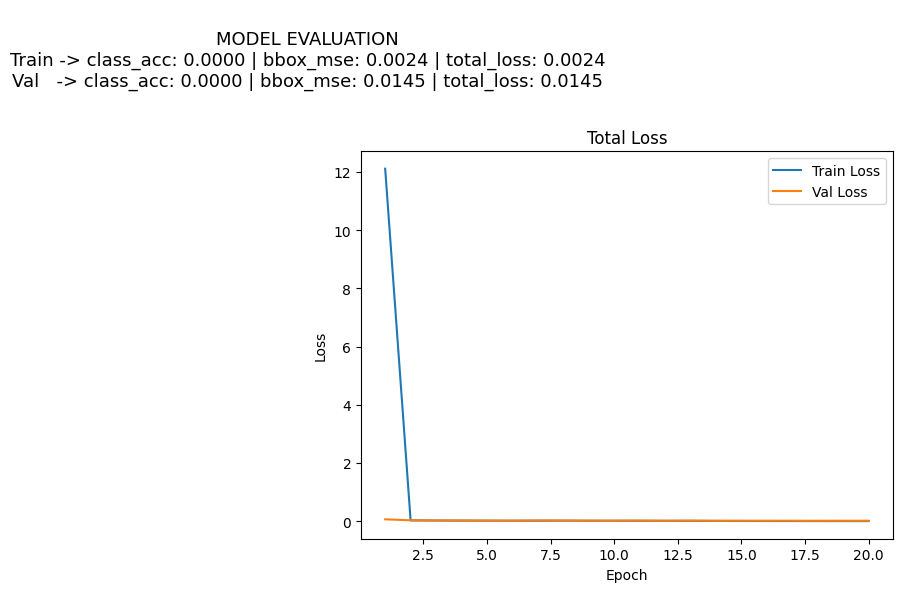

In [8]:
# Non-repeating eval datasets
def eval_ds_from_df(dframe):
    ds = create_dataset_from_dataframe(dframe, use_norm_cols=True)
    ds = ds.map(lambda p, y: (load_normalize_image(p, [SIZE, SIZE], channels=1), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    return ds

train_eval_ds = eval_ds_from_df(train_df)
val_eval_ds   = eval_ds_from_df(val_df)

eval_train = model.evaluate(train_eval_ds, verbose=2, return_dict=True)
eval_val   = model.evaluate(val_eval_ds,   verbose=2, return_dict=True)

model_evaluation_info = f"""
MODEL EVALUATION
Train -> class_acc: {eval_train.get('class_accuracy', float('nan')):.4f} | bbox_mse: {eval_train.get('bbox_mse', float('nan')):.4f} | total_loss: {eval_train.get('loss', float('nan')):.4f}
Val   -> class_acc: {eval_val.get('class_accuracy', float('nan')):.4f} | bbox_mse: {eval_val.get('bbox_mse', float('nan')):.4f} | total_loss: {eval_val.get('loss', float('nan')):.4f}
"""
print(model_evaluation_info)
plot_history(history, model_evaluation_info)


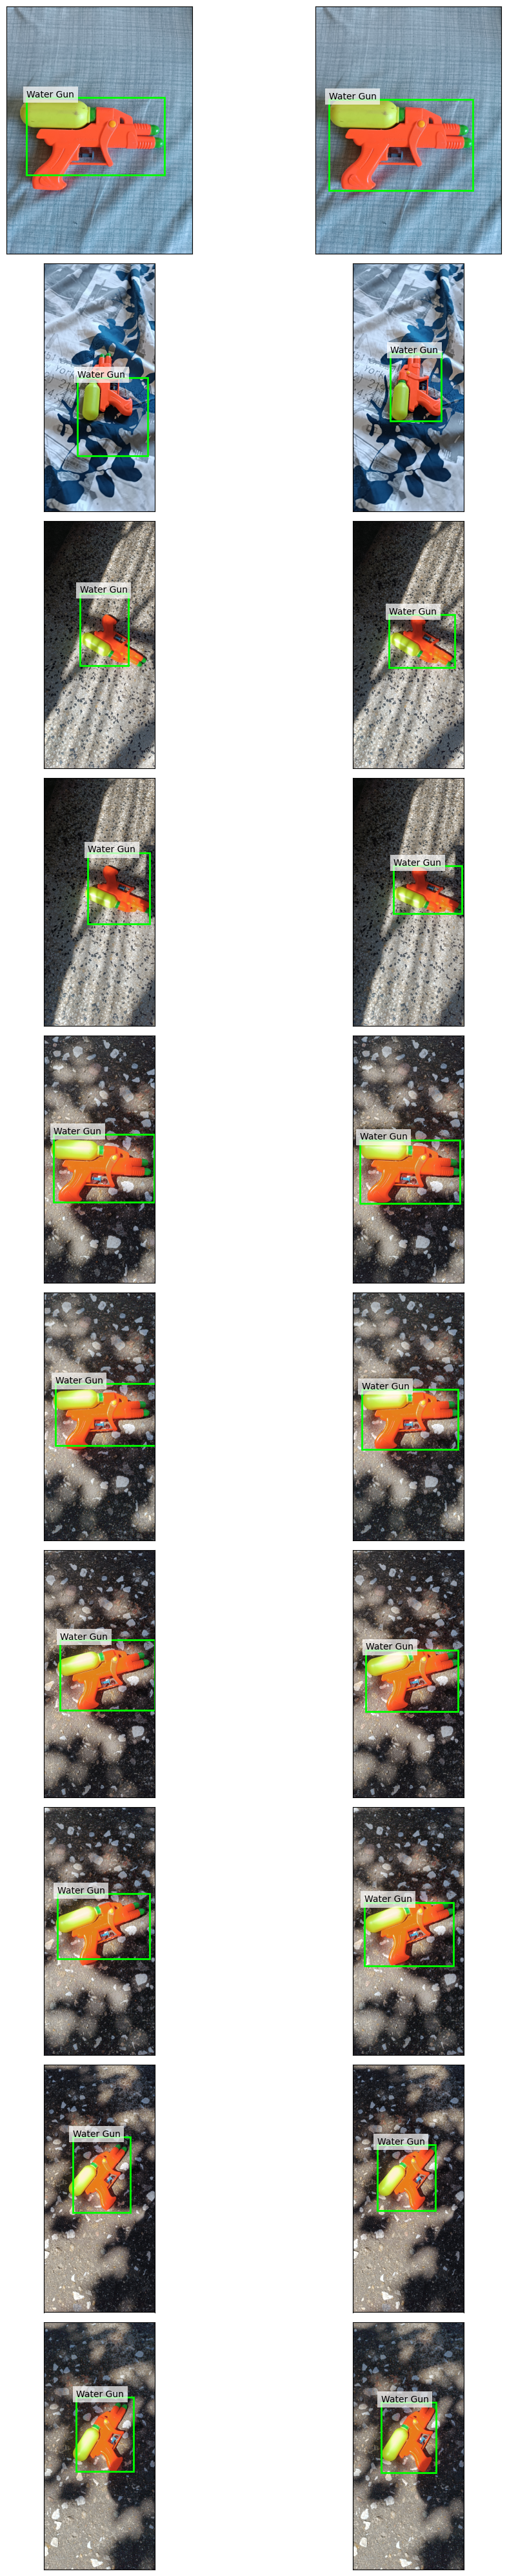

In [9]:
# Predict on first N items from the (normalized) dataframe
N = min(10, len(df))
pred_bboxes = []
pred_classes = []

for i in range(N):
    image_path = df.iloc[i]['filename']
    image = load_normalize_image(image_path, [SIZE, SIZE], channels=1)
    logits_bbox, logits_class = model.predict(tf.expand_dims(image, 0), verbose=0)
    pred_bboxes.append(np.squeeze(logits_bbox))                 # normalized [0,1]
    pred_classes.append(np.argmax(np.squeeze(logits_class)))

pred_bboxes = np.array(pred_bboxes, dtype=np.float32)
pred_classes = np.array(pred_classes, dtype=np.int32)

# Visualize predictions vs ground truth
plot_predictions(
    pred_bboxes=pred_bboxes,
    pred_classes=pred_classes,
    dataframe_original=df,        # uses normalized cols inside
    box_color='lime',
    class_names=["Water Gun"]
)
